# Load text data


What I will implement is a sereies of codes to classify a IMDB dataset which consist of evenly distributed classes (50% positive reviews and 50% negative reviews), I will implement Logistic regression, decision trees and random forest, ultimately I will try to implement a MLP. 

First, we load the necessary libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import tensorflow as tf
%matplotlib inline


Now we load the dataset

In [2]:
movie_data = pd.read_csv('./Data/IMDB Dataset.csv')
movie_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
movie_data.shape

(50000, 2)

Since we know this data is evenly distributed we can evaluate our models with A ROC curve and learning curve. but first we neet to do a preprocessing, since our data does not look 'clean' (from the review column we se that we have "$<br/>$" brackets and for training a model with text using Natural Language Processing we need to clean as much as we can).

## Processing data


In [4]:
### We will process all text data from upper cases to lower cases, we use the re package to search patterns in a string case
import re
import string
def cleanse_text_1(text):
    text = text.lower()
    #replace the substrings that match with the search pattern with a string of our choice.
    text = re.sub('\[.*?\]', '', text)
    #we use re.escape() to escape all special characters
    text = re.sub('[%s]'%re.escape(string.punctuation),'',text)
    #to search for word characters we use \w and \d for digits
    text = re.sub('\w*\d\w*','',text)
    return text
cleanse1 = lambda x:cleanse_text_1(x)

Now we will implement the function 'cleanse_text_1' to our database

In [5]:
movie_data['review'] = pd.DataFrame(movie_data.review.apply(cleanse1))
movie_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


Look on how the data has no upper cases and looks more clean


We move forward by replacing any sort of strange punctuation left, such as spaces, commas, etc

In [6]:
def cleanse_text_2(text):
    text=re.sub('[''"",,,]','',text)
    #we replace any line jump \n 
    text=re.sub('\n','',text)
    return text
cleanse2 = lambda x:cleanse_text_2(x)

We apply our second filter to our dataset 

In [7]:
movie_data['review'] = pd.DataFrame(movie_data.review.apply(cleanse2))
movie_data.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [8]:
movie_data.tail()

,review,sentiment
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative
49999,no one expects the star trek movies to be high...,negative


We can move forward and split our data in the train_test_split section

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

We will select our features $x$ as the first column values and our target as the second column values, we will then create a pipeline for our models to train and test, for our features we will get arrays of shape(50000,).

Since our labels are strings such as 'Positive' and 'Negative', we would like to encode them in order to evaluate our model with proper values, such as 0 for 'Negative' and 1 for 'Positive'.

In [12]:
copy_movie_data = movie_data.copy(deep=True)


In [13]:
copy_movie_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production br br the filmin...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,bad plot bad dialogue bad acting idiotic direc...,negative
49997,i am a catholic taught in parochial elementary...,negative
49998,im going to have to disagree with the previous...,negative


In [15]:
from sklearn.preprocessing import LabelEncoder
label = LabelEncoder() 
 
copy_movie_data['sentiment']= label.fit_transform(copy_movie_data['sentiment']) 
print(copy_movie_data['sentiment'].unique())


[1 0]


We see now there is a 0 instead of 'negative' and 1 instead of 'positive', this will make gurther computations easy

In [17]:
copy_movie_data

,review,sentiment
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the filmin...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically theres a family where a little boy j...,0
4,petter matteis love in the time of money is a ...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,i am a catholic taught in parochial elementary...,0
49998,im going to have to disagree with the previous...,0


In [18]:
x = movie_data.iloc[0:,0].values
y = movie_data.iloc[0:,1].values
y_encoded = copy_movie_data.iloc[0:,1].values

In [19]:
x.shape

(50000,)

In [20]:
print(x)

['one of the other reviewers has mentioned that after watching just  oz episode youll be hooked they are right as this is exactly what happened with mebr br the first thing that struck me about oz was its brutality and unflinching scenes of violence which set in right from the word go trust me this is not a show for the faint hearted or timid this show pulls no punches with regards to drugs sex or violence its is hardcore in the classic use of the wordbr br it is called oz as that is the nickname given to the oswald maximum security state penitentary it focuses mainly on emerald city an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda em city is home to manyaryans muslims gangstas latinos christians italians irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awaybr br i would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare fo

For our next step, we will split our train and test sets in a 80/20 (80% training, 20% testing) scenario, I like to do this to ensure efficiency of the model, we can see, however, if the model can be better with less training and more testing further on.

In [144]:
X_train, X_test, y_train, y_test = train_test_split(x, y_encoded, test_size = 0.20, random_state = 43)

In [145]:
y_test

array([1, 1, 1, ..., 1, 1, 0])

The Tfidf vectorizer module on sklearn allows us to convert any text found in pure dataset in a sort of matrix of Term Frequency Inverse Document Frequency. This allows us to transform the text in a more meaningful data representing numbers four our ML model, it counts the frequency of text found in the array and makes a matrix of elements which is more easy to understand.

In [146]:
from sklearn.pipeline import Pipeline
tf = TfidfVectorizer()

## Now we focus on building our first model

In [147]:
from sklearn.linear_model import LogisticRegression
classifier1 = LogisticRegression()
model1 = Pipeline([('vectorizer', tf), ('classifier', classifier1)])

model1.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier', LogisticRegression())])

In [148]:
y_pred_1 = model1.predict(X_test)
y_pred_1

array([0, 1, 1, ..., 1, 0, 0])

In [149]:
accuracy_score(y_pred_1, y_test)

0.8938

This next module helps us to visualize a confusion matrix

In [150]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

Normalized confusion matrix
[[0.88 0.12]
 [0.1  0.9 ]]


<Figure size 432x288 with 0 Axes>

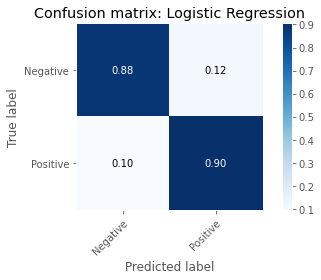

In [151]:

class_names=['Negative','Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, y_pred_1, classes=class_names,normalize = True,
                      title='Confusion matrix: Logistic Regression')
plt.grid(False)

### ROC Curve


It tells us the trade off between the true positive and false positive elements computed by the algorithm

Random prediction: AUC = 0.500
Logistic Regression: AUC = 0.894


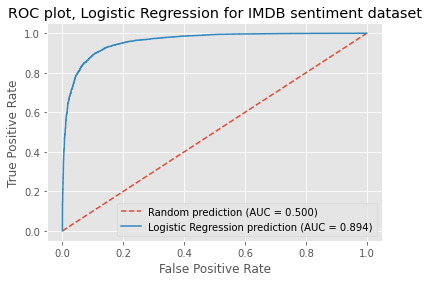

In [152]:
plt.style.use('ggplot')
#random probabilities: our model is not learning
r_probs = [0 for _ in range(len(y_test))]
#logistic regression probabilities
lr_probs = model1.predict_proba(X_test)
#We will use only positive values
lr_probs = lr_probs[:,1]

from sklearn.metrics import roc_auc_score, roc_curve, auc

#random area under curve
r_auc = roc_auc_score(y_test, r_probs)
#logistic recression area under curve
lr_auc = roc_auc_score(y_test, y_pred_1)

print("Random prediction: AUC = %.3f" % (r_auc))
print("Logistic Regression: AUC = %.3f" % (lr_auc))

#True positive ratio and false positive ratio computations
# Random Choice
r_fpr, r_tpr, _= roc_curve(y_test, r_probs)
#Logistic regression model
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
#we plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUC = %0.3f)' % r_auc)
#logistic regression model
plt.plot(lr_fpr, lr_tpr, linestyle='-', label = 'Logistic Regression prediction (AUC = %0.3f)' % lr_auc)
plt.title('ROC plot, Logistic Regression for IMDB sentiment dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()



It looks pretty neat! In fact it seems it is almost perfect, let´s do a cross validation testing to see if our model is not overfitting

In [34]:
from sklearn.model_selection import learning_curve
#We create CV training and test scores for various training set sizes
train_sizes, train_scores, test_scores = learning_curve(model1,
                                                     x,
                                                     y_encoded,
                                                     #Number of folds in cross validation
                                                     cv = 10,
                                                     #Evaluation metric
                                                     scoring = 'accuracy',
                                                     #use all computers
                                                     n_jobs = -1,
                                                     # 50 different sizes of training set
                                                     train_sizes = np.linspace(0.01, 1.0, 50))

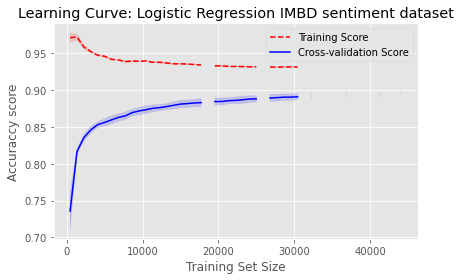

In [36]:
#create means and standard deviations for train set scores

train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)

#create mean and standar deviations for test set scores

test_mean = np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

#Draw Lines 
plt.plot(train_sizes, train_mean, '--', color = 'r', label = 'Training Score')
plt.plot(train_sizes, test_mean, color = 'b', label = 'Cross-validation Score')

#Draw standard deviation
plt.fill_between(train_sizes,
                 train_mean - train_std,
                 train_mean + train_std,
                 color ='r', alpha = 0.15)

plt.fill_between(train_sizes,
                 test_mean - test_std,
                 test_mean + test_std,
                 color ='b', alpha = 0.15)

#create plot
plt.title("Learning Curve: Logistic Regression IMBD sentiment dataset")
plt.xlabel("Training Set Size"), plt.ylabel("Accuraccy score"), plt.legend(loc="best")
plt.tight_layout()
plt.show()

It looks correct and ready to go, the training and corss validation curves seems to not to tend the overfit or underfit, they look like they will follow a parallel line, which is incredible. Let's now focus on using 2 other classification algorithms, decision trees and random forests

## Decission tree Classifier


In [127]:
#from sklearn.model_selection import RandomizedSearchCV
#we only have one feature
#max_features = ['auto', 1]
#Maximum number of levels in tree
#max_depth = [int(x) for x in np.linspace(1, 10, num = 10)]
#max_depth.append(None)
#minimum of samples required to split a node
#min_samples_split = [20, 50, 100, 200, 1000]
#Minumum samples required at each leaf node
#min_samples_leaf = [10, 20, 45, 100]
#we create a dictionary of random values in our grid
#random_grid_DT = {'max_features':max_features,
#                  'max_depth':max_depth,
#                  'min_samples_split':min_samples_split,
#                  'min_samples_leaf':min_samples_leaf}

#pprint(random_grid_DT)
from sklearn.tree import DecisionTreeClassifier
##We use criterion=entropy for binary classification tasks (in my personal opinion it's best than Gini Index)
classifier2 = DecisionTreeClassifier(criterion='entropy', class_weight='balanced', min_samples_leaf=200, max_depth=20, min_samples_split=20)
model2 = Pipeline([('vectorizer', tf), ('classifier', classifier2)])



#dt_random = RandomizedSearchCV(estimator = classifier2, param_distributions=random_grid_DT, n_iter=100, cv = 3, verbose=2,
 #                             random_state = 0, n_jobs=-1)

#dt_random.fit(X_train, y_train)

In [128]:
from sklearn.tree import DecisionTreeClassifier
##We use criterion=entropy for binary classification tasks (in my personal opinion it's best than Gini Index)
classifier2 = DecisionTreeClassifier(criterion='entropy',
                                     class_weight='balanced',
                                     min_samples_leaf=500,
                                     max_depth=100,
                                     min_samples_split=500)
model2 = Pipeline([('vectorizer', tf), ('classifier', classifier2)])


In [129]:
model2.fit(X_train, y_train)

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced',
                                        criterion='entropy', max_depth=100,
                                        min_samples_leaf=500,
                                        min_samples_split=500))])

In [130]:
y_pred_2 = model2.predict(X_test)

In [131]:
y_pred_2

array([0, 0, 0, ..., 1, 0, 1])

Normalized confusion matrix
[[0.7  0.3 ]
 [0.26 0.74]]


<Figure size 432x288 with 0 Axes>

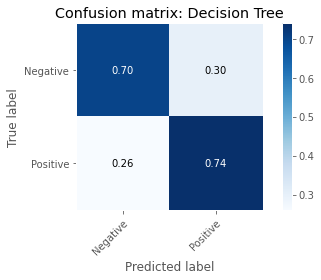

In [132]:
class_names=['Negative','Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, y_pred_2, classes=class_names,normalize = True,
                      title='Confusion matrix: Decision Tree')
plt.grid(False)
plt.show()

Random prediction: AUC = 0.500
Decision Tree: AUC = 0.720


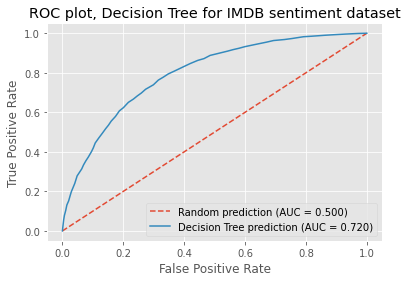

In [133]:
plt.style.use('ggplot')
#random probabilities: our model is not learning
r_probs = [0 for _ in range(len(y_test))]
#logistic regression probabilities
dt_probs = model2.predict_proba(X_test)
#We will use only positive values
dt_probs = dt_probs[:,1]

from sklearn.metrics import roc_auc_score, roc_curve, auc

#random area under curve
r_auc = roc_auc_score(y_test, r_probs)
#logistic recression area under curve
dt_auc = roc_auc_score(y_test, y_pred_2)

print("Random prediction: AUC = %.3f" % (r_auc))
print("Decision Tree: AUC = %.3f" % (dt_auc))

#True positive ratio and false positive ratio computations
# Random Choice
r_fpr, r_tpr, _= roc_curve(y_test, r_probs)
#Decision Tree model
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
#we plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUC = %0.3f)' % r_auc)
#Decision tree model
plt.plot(dt_fpr, dt_tpr, linestyle='-', label = 'Decision Tree prediction (AUC = %0.3f)' % dt_auc)
plt.title('ROC plot, Decision Tree for IMDB sentiment dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()



In [161]:
from sklearn.ensemble import RandomForestClassifier
##We use criterion=entropy for binary classification tasks (in my personal opinion it's best than Gini Index)
classifier3 = RandomForestClassifier(n_estimators=3000,
                                     criterion='entropy',
                                     class_weight='balanced',
                                     min_samples_leaf=500,
                                     max_depth=100,
                                     min_samples_split=500)
model3 = Pipeline([('vectorizer', tf), ('classifier', classifier3)])


In [162]:
model3.fit(X_train, y_train)
y_pred_3 = model3.predict(X_test)

Normalized confusion matrix
[[0.78 0.22]
 [0.18 0.82]]


<Figure size 432x288 with 0 Axes>

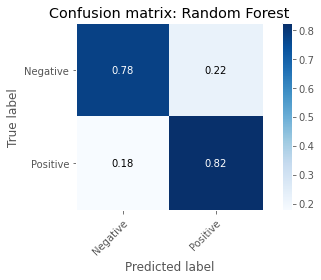

In [163]:
class_names=['Negative','Positive']
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(y_test, y_pred_3, classes=class_names,normalize = True,
                      title='Confusion matrix: Random Forest')
plt.grid(False)
plt.show()

Random prediction: AUC = 0.500
Random Forest: AUC = 0.799


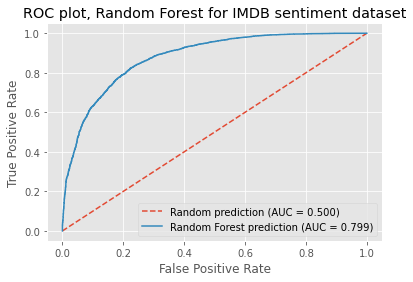

In [164]:
plt.style.use('ggplot')
#random probabilities: our model is not learning
r_probs = [0 for _ in range(len(y_test))]
#logistic regression probabilities
rf_probs = model3.predict_proba(X_test)
#We will use only positive values
rf_probs = rf_probs[:,1]

from sklearn.metrics import roc_auc_score, roc_curve, auc

#random area under curve
r_auc = roc_auc_score(y_test, r_probs)
#logistic recression area under curve
rf_auc = roc_auc_score(y_test, y_pred_3)

print("Random prediction: AUC = %.3f" % (r_auc))
print("Random Forest: AUC = %.3f" % (rf_auc))

#True positive ratio and false positive ratio computations
# Random Choice
r_fpr, r_tpr, _= roc_curve(y_test, r_probs)
#Random Forest model
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
#we plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUC = %0.3f)' % r_auc)
#Random Forest model
plt.plot(rf_fpr, rf_tpr, linestyle='-', label = 'Random Forest prediction (AUC = %0.3f)' % rf_auc)
plt.title('ROC plot, Random Forest for IMDB sentiment dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.legend()

plt.show()

## Which model is best?

#### So far, it seems that Logistic Regression has the advantage over the 2 other classifiers, this could be because the main target for decision trees and forest focuses more on the patterns of the data, whilst logistic regression has the advantage of using the tfidfVectorizer and simply use the sigmoid $\sigma(x)$ function while counting the words it may find.

Text(0, 0.5, 'True Positive Rate')

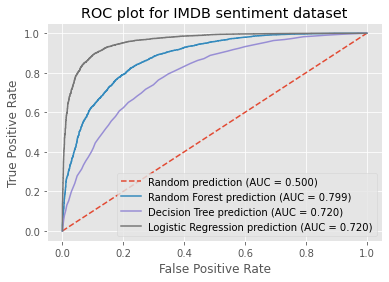

In [166]:
#we plot the ROC curve
plt.plot(r_fpr, r_tpr, linestyle='--', label = 'Random prediction (AUC = %0.3f)' % r_auc)
#Random Forest model
plt.plot(rf_fpr, rf_tpr, linestyle='-', label = 'Random Forest prediction (AUC = %0.3f)' % rf_auc)
#Decision tree model
plt.plot(dt_fpr, dt_tpr, linestyle='-', label = 'Decision Tree prediction (AUC = %0.3f)' % dt_auc)
#Logistic Regression model
plt.plot(lr_fpr, lr_tpr, linestyle='-', label = 'Logistic Regression prediction (AUC = %0.3f)' % dt_auc)
plt.legend(loc='best')
plt.title('ROC plot for IMDB sentiment dataset')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')